# EDA


In [1]:
from collections import Counter
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from wordcloud import WordCloud, STOPWORDS

sns.set_theme()
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("./datasets/labeled_projects.csv")

## Tag distribution

[Text(0, 0, 'natural-language-processing'),
 Text(1, 0, 'computer-vision'),
 Text(2, 0, 'mlops'),
 Text(3, 0, 'reinforcement-learning'),
 Text(4, 0, 'graph-learning'),
 Text(5, 0, 'time-series')]

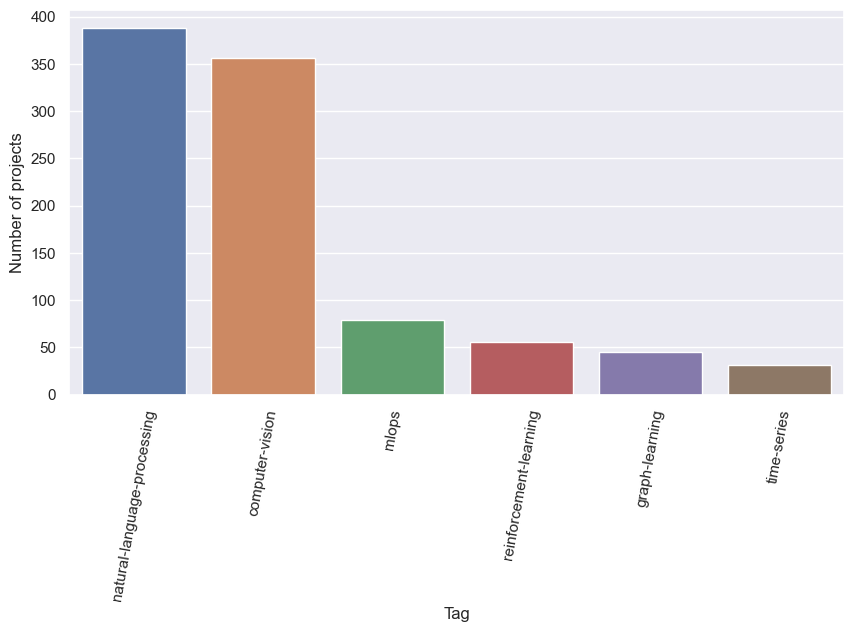

In [3]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(df["tag"].sort_values(), order=df["tag"].value_counts().index)
plt.xlabel("Tag")
plt.ylabel("Number of projects")
ax.set_xticklabels(labels=df["tag"].value_counts().index, rotation=80)

# Wordcloud

In [4]:
# Most common tags
tags = Counter(df.tag.values)
tags.most_common()

[('natural-language-processing', 388),
 ('computer-vision', 356),
 ('mlops', 79),
 ('reinforcement-learning', 56),
 ('graph-learning', 45),
 ('time-series', 31)]

In [5]:
# Most frequent tokens for each tag
@widgets.interact(tag=list(tags))
def display_word_cloud(tag="natural-language-processing"):
    # Plot word clouds top top tags
    plt.figure(figsize=(15, 5))
    subset = df[df.tag == tag]
    text = subset.title.values
    cloud = WordCloud(
        stopwords=STOPWORDS,
        background_color="black",
        collocations=False,
        width=500,
        height=300,
    ).generate(" ".join(text))
    plt.axis("off")
    plt.imshow(cloud)

interactive(children=(Dropdown(description='tag', index=3, options=('computer-vision', 'graph-learning', 'rein…

# Preprocessing

In [6]:
df.shape

(955, 5)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955 entries, 0 to 954
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           955 non-null    int64 
 1   created_on   955 non-null    object
 2   title        955 non-null    object
 3   description  955 non-null    object
 4   tag          955 non-null    object
dtypes: int64(1), object(4)
memory usage: 37.4+ KB


In [8]:
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning


## Missings

In [9]:
df.isnull().sum()

id             0
created_on     0
title          0
description    0
tag            0
dtype: int64

## Feature engineering

In [10]:
df["text"] = df["title"] + " " + df["description"]

## Cleaning

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [12]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ms101\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [13]:
def clean_text(text, lower=True, stem=False, stopwords=STOPWORDS):
    if lower:
        text = text.lower()

    # remove stopwords
    if len(stopwords):
        pattern = re.compile(r"\b(" + r"|".join(stopwords) + r")\b\s*")
        text = pattern.sub("", text)
    # Spacing and filters
    text = re.sub(
        r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text
    )  # add spacing between objects to be filtered
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends

    # Remove links
    text = re.sub(r"http\S+", "", text)

    # Stemming
    if stem:
        text = " ".join(
            [stemmer.stem(word, to_lowercase=lower) for word in text.split(" ")]
        )

    return text

In [14]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text, lower=True, stem=False)
print(f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


### Replace labels

Based on our findings from EDA, we're going to apply several constraints for labeling our data:

if a data point has a tag that we currently don't support, we'll replace it with other
if a certain tag doesn't have enough samples, we'll replace it with other

In [15]:
import json

ACCEPTED_TAGS = [
    "natural-language-processing",
    "computer-vision",
    "mlops",
    "graph-learning",
]

In [16]:
# Out of scope (OOS) tags
oos_tags = [item for item in df.tag.unique() 
                    if item not in ACCEPTED_TAGS]
oos_tags

['reinforcement-learning', 'time-series']

In [17]:
# Samples with OOS tags
oos_indices = df[df.tag.isin(oos_tags)].index
df[df.tag.isin(oos_tags)].head()


,id,created_on,title,description,tag,text
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning,awesome monte carlo tree search curated list m...
37,121,2020-03-24 04:56:38,Deep Reinforcement Learning in TensorFlow2,deep-rl-tf2 is a repository that implements a ...,reinforcement-learning,deep reinforcement learning tensorflow2 deep r...
67,218,2020-04-06 11:29:57,Distributional RL using TensorFlow2,🐳 Implementation of various Distributional Rei...,reinforcement-learning,distributional rl using tensorflow2 implementa...
74,239,2020-04-06 18:39:48,Prophet: Forecasting At Scale,Tool for producing high quality forecasts for ...,time-series,prophet forecasting scale tool producing high ...
95,277,2020-04-07 00:30:33,Curriculum for Reinforcement Learning,Curriculum learning applied to reinforcement l...,reinforcement-learning,curriculum reinforcement learning curriculum l...


In [18]:
# Replace this tag with "other"
df.tag = df.tag.apply(lambda x: "other" if x in oos_tags else x)
df.iloc[oos_indices].head()

,id,created_on,title,description,tag,text
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other,awesome monte carlo tree search curated list m...
37,121,2020-03-24 04:56:38,Deep Reinforcement Learning in TensorFlow2,deep-rl-tf2 is a repository that implements a ...,other,deep reinforcement learning tensorflow2 deep r...
67,218,2020-04-06 11:29:57,Distributional RL using TensorFlow2,🐳 Implementation of various Distributional Rei...,other,distributional rl using tensorflow2 implementa...
74,239,2020-04-06 18:39:48,Prophet: Forecasting At Scale,Tool for producing high quality forecasts for ...,other,prophet forecasting scale tool producing high ...
95,277,2020-04-07 00:30:33,Curriculum for Reinforcement Learning,Curriculum learning applied to reinforcement l...,other,curriculum reinforcement learning curriculum l...


In [19]:
# Minimum frequency required for a tag
min_freq = 75
tags = Counter(df.tag.values)


In [20]:
# Tags that just made / missed the cut
@widgets.interact(min_freq=(0, tags.most_common()[0][1]))
def separate_tags_by_freq(min_freq=min_freq):
    tags_above_freq = Counter(tag for tag in tags.elements()
                                    if tags[tag] >= min_freq)
    tags_below_freq = Counter(tag for tag in tags.elements()
                                    if tags[tag] < min_freq)
    print ("Most popular tags:\n", tags_above_freq.most_common(3))
    print ("\nTags that just made the cut:\n", tags_above_freq.most_common()[-3:])
    print ("\nTags that just missed the cut:\n", tags_below_freq.most_common(3))


interactive(children=(IntSlider(value=75, description='min_freq', max=388), Output()), _dom_classes=('widget-i…

In [21]:
def filter(tag, include=[]):
    """Determine if a given tag is to be included."""
    if tag not in include:
        tag = None
    return tag


In [22]:
# Filter tags that have fewer than <min_freq> occurrences
tags_above_freq = Counter(tag for tag in tags.elements()
                          if (tags[tag] >= min_freq))
df.tag = df.tag.apply(filter, include=list(tags_above_freq.keys()))


In [23]:
# Fill None with other
df.tag = df.tag.fillna("other")


In [24]:
import numpy as np
import random


In [25]:
# Get data
X = df.text.to_numpy()
y = df.tag


In [26]:
## write own Labelencoder based on scikit-learn
class LabelEncoder():
    def __init__(self):
        self.class_to_index = {}


    @property
    def classes(self):
        return list(self.class_to_index.keys())

    @property
    def index_to_class(self):
        return {v: k for k, v in self.class_to_index.items()}

    def fit(self,y):
        """Fit the label encoder"""
        unique_labels = np.unique(y)
        for i,label in enumerate(unique_labels):
            self.class_to_index[label] = i
        return self

    def transform(self,y):
        """Transform labels to normalized encoding"""
        _y = []
        for label in y:
            _y.append(self.class_to_index.get(label))
        return np.array(_y)

    def encode(self, y):
        """Alternative for transform, implemented as course uses encode/decode"""
        return self.transform(y)

    def inverse_transform(self,y):
        _y = []
        for index in y:
            _y.append(self.index_to_class.get(index))
        return _y

    def decode(self,y):
        return self.inverse_transform(y)


    def fit_transform(self,y):
        self.fit(y)
        _y = self.transform(y)
        return _y

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {"class_to_index": self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)


    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"
        
    def __repr__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

In [27]:
ACCEPTED_TAGS

['natural-language-processing', 'computer-vision', 'mlops', 'graph-learning']

In [28]:
test_encoder = LabelEncoder()
test_encoder.fit(ACCEPTED_TAGS)

<LabelEncoder(num_classes=4)>

In [29]:
test_encoder.classes

['computer-vision', 'graph-learning', 'mlops', 'natural-language-processing']

In [30]:
test_encoder.class_to_index

{'computer-vision': 0,
 'graph-learning': 1,
 'mlops': 2,
 'natural-language-processing': 3}

In [31]:
test_encoder.transform(['natural-language-processing', 'computer-vision', 'mlops', 'graph-learning'])


array([3, 0, 2, 1])

In [32]:
test_encoder.fit_transform(['natural-language-processing', 'computer-vision', 'mlops', 'graph-learning','other'])


array([3, 0, 2, 1, 4])

In [33]:
# Encode
label_encoder = LabelEncoder()
label_encoder.fit(y)
num_classes = len(label_encoder)

In [34]:
label_encoder.class_to_index


{'computer-vision': 0,
 'mlops': 1,
 'natural-language-processing': 2,
 'other': 3}

In [35]:
label_encoder.index_to_class


{0: 'computer-vision',
 1: 'mlops',
 2: 'natural-language-processing',
 3: 'other'}

In [36]:
# Encode
label_encoder.encode(["computer-vision", "mlops", "mlops"])


array([0, 1, 1])

In [37]:
# Decode
label_encoder.decode(np.array([0, 1, 1]))


['computer-vision', 'mlops', 'mlops']

In [38]:
# Encode all our labels
y = label_encoder.encode(y)
print (y.shape)


(955,)


## Splitting

In [39]:
from sklearn.model_selection import train_test_split

train_size = 0.7
test_size = 0.15
valid_size = 0.15

In [40]:
X_train, X_, y_train, y_ = train_test_split(X,y,train_size = train_size,stratify=y)
print (f"train: {len(X_train)} ({(len(X_train) / len(X)):.2f})\n"
       f"remaining: {len(X_)} ({(len(X_) / len(X)):.2f})")


train: 668 (0.70)
remaining: 287 (0.30)


In [41]:
# Split (test)
X_val, X_test, y_val, y_test = train_test_split(
    X_, y_, train_size=0.5, stratify=y_)

print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")


train: 668 (0.70)
val: 143 (0.15)
test: 144 (0.15)


In [42]:
# Get counts for each class
counts = {}
counts["train_counts"] = {tag: label_encoder.decode(y_train).count(tag) for tag in label_encoder.classes}
counts["val_counts"] = {tag: label_encoder.decode(y_val).count(tag) for tag in label_encoder.classes}
counts["test_counts"] = {tag: label_encoder.decode(y_test).count(tag) for tag in label_encoder.classes}


# View distributions
pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)

,computer-vision,mlops,natural-language-processing,other
train,249,55,272,92
val,53,12,58,20
test,54,12,58,20


In [43]:
# Split DataFrames
train_df = pd.DataFrame({"text": X_train, "tag": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"text": X_val, "tag": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"text": X_test, "tag": label_encoder.decode(y_test)})
train_df.head()


,text,tag
0,unsupervised question decomposition question a...,natural-language-processing
1,tensorflowtts real time sota speech synthesis ...,natural-language-processing
2,network fusion content creation conditional in...,computer-vision
3,learning word embedding post introduces severa...,natural-language-processing
4,evolution strategies evolutionary algorithms r...,other


## Augmentation